In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression

In [140]:
train = pd.read_csv('Train.csv')
train.head()

,geo_longitude,geo_latitude,altitude_pressure,climb_rate,gps_altitude,air_speed,flight_track
0,-12.4952,54.9829,-580.9066,-4.2506,3107.9575,221.6929,10.9369
1,53.6539,30.3566,6565.8130,16.1493,-920.0656,38.4727,317.1208
2,-80.7304,44.2387,6158.0963,-0.7801,-1287.7323,83.8126,220.1877
3,20.7860,17.4654,11321.8167,9.5402,10969.4723,194.1098,216.1874
4,-85.3823,32.2703,4594.6961,0.4988,1710.2622,323.4483,312.5270


In [141]:
train.shape

(14667, 7)

In [142]:
train.isnull().sum()

geo_longitude        0
geo_latitude         0
altitude_pressure    0
climb_rate           0
gps_altitude         0
air_speed            0
flight_track         0
dtype: int64

In [143]:
train.duplicated().sum()

0

In [144]:
train.describe()

,geo_longitude,geo_latitude,altitude_pressure,climb_rate,gps_altitude,air_speed,flight_track
count,14667.000000,14667.000000,14667.000000,14667.000000,14667.000000,14667.000000,14667.000000
mean,7.536491,36.198809,5696.875149,-0.047858,5996.039786,252.642769,183.581953
std,65.897009,19.295113,4105.676176,6.439259,4307.798064,145.849958,104.620031
min,-250.955400,-38.483700,-12629.244600,-25.565300,-13147.878800,0.051800,-247.598200
25%,-36.507400,22.928900,2897.676000,-4.423500,3134.058700,126.336750,113.459250
50%,7.427800,36.290200,5696.431700,-0.032000,5983.781500,252.616500,183.971500
75%,51.585050,49.362800,8505.526700,4.276150,8875.635900,378.973900,254.403600
max,266.127000,123.049500,20986.201000,24.225000,22387.300800,505.236600,572.320200


In [145]:
test = pd.read_csv('Test.csv')
test.head()

,geo_longitude,geo_latitude,altitude_pressure,climb_rate,gps_altitude,air_speed,flight_track
0,30.9405,27.3240,9876.0457,4.6816,6668.9116,343.3593,NaN
1,-24.7090,49.5467,6649.8123,-3.8259,6613.2840,450.2234,NaN
2,74.3912,45.4424,5897.6168,-5.2746,5153.9864,254.1239,NaN
3,-28.3424,38.5080,7889.2532,3.6315,9029.3020,22.5294,NaN
4,79.8940,54.4288,1599.1477,-3.5135,-2000.8589,388.2260,NaN


In [146]:
test.shape

(300, 7)

In [147]:
test.isnull().sum()

geo_longitude          0
geo_latitude           0
altitude_pressure      0
climb_rate             0
gps_altitude           0
air_speed              0
flight_track         300
dtype: int64

In [148]:
test.duplicated().sum()

0

In [149]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(14967, 7)

C:\Users\ahpat\AppData\Local\Temp\ipykernel_21228\1596057305.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['flight_track'], kde = True)


<Axes: xlabel='flight_track', ylabel='Density'>

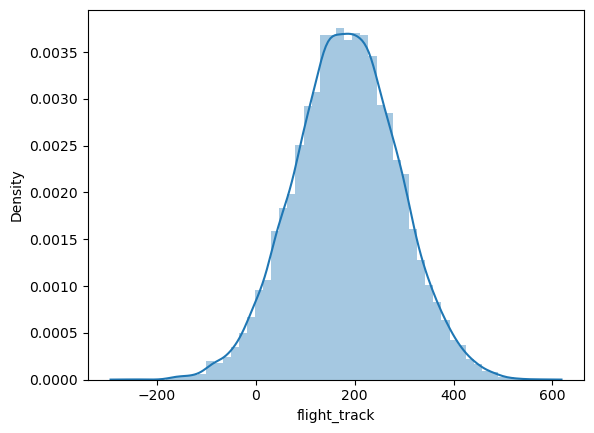

In [150]:
sns.distplot(train['flight_track'], kde = True)

In [151]:
input_variables = combined.drop('flight_track', axis = 1)

In [152]:
def replace_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    median_value = df[column].median()
    df[column] = np.where((df[column]<lower)|(df[column]>upper), median_value, df[column])
    return df

In [153]:
for col in input_variables.columns:
    concat_df = replace_outliers(combined, col)

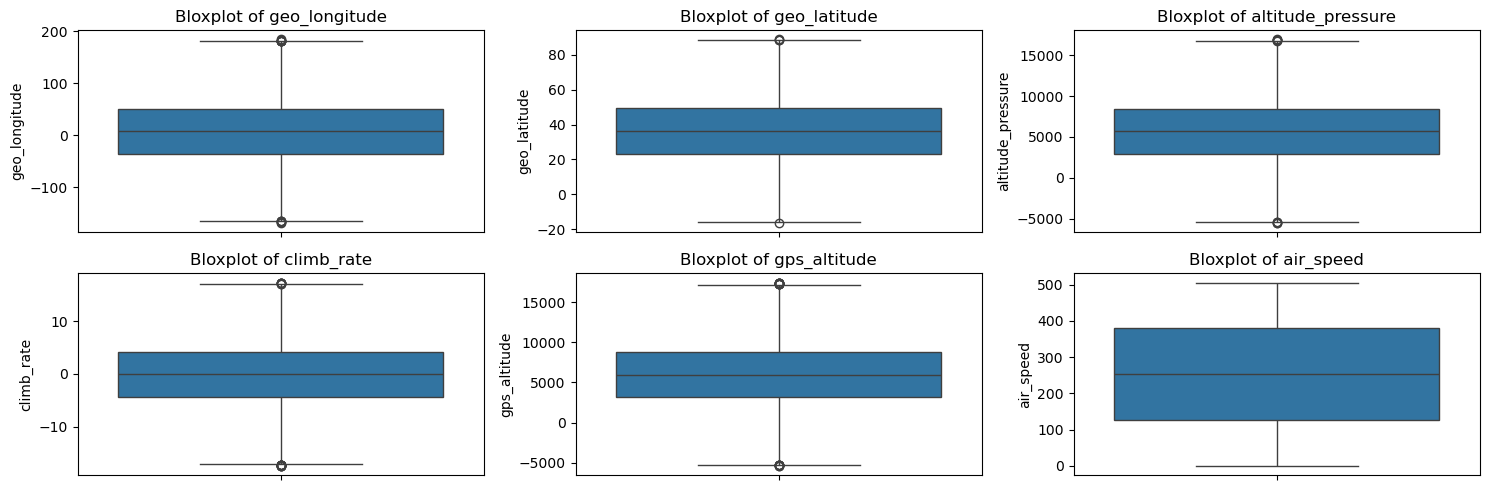

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(input_variables.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [155]:
combined['lat_rad'] = np.radians(combined['geo_latitude'])
combined['lon_rad'] = np.radians(combined['geo_longitude'])
R = 6371e3  # Earth radius in meters
combined['dlat'] = combined['lat_rad'].diff()
combined['dlon'] = combined['lon_rad'].diff()

a = (np.sin(combined['dlat']/2)**2 +np.cos(combined['lat_rad']).shift() * np.cos(combined['lat_rad']) *np.sin(combined['dlon']/2)**2)
combined['haversine_distance'] = 2 * R * np.arcsin(np.sqrt(a))  # meters
combined['ground_speed'] = combined['haversine_distance']
y = np.sin(combined['dlon']) * np.cos(combined['lat_rad'])
x = (np.cos(combined['lat_rad'].shift()) * np.sin(combined['lat_rad']) - np.sin(combined['lat_rad'].shift()) * np.cos(combined['lat_rad']) *
     np.cos(combined['dlon']))

combined['bearing'] = np.degrees(np.arctan2(y, x))
combined['bearing'] = (combined['bearing'] + 360) % 360
combined['bearing_change'] = combined['bearing'].diff()
combined['bearing_change'] = ((combined['bearing_change'] + 180) % 360) - 180
combined['abs_bearing_change'] = combined['bearing_change'].abs()

combined['altitude_diff'] = combined['altitude_pressure'].diff()
combined['gps_altitude_diff'] = combined['gps_altitude'].diff()
combined['climb_rate_diff'] = combined['climb_rate'].diff()

combined['airspeed_diff'] = combined['air_speed'].diff()
combined['acceleration'] = combined['airspeed_diff']
combined.drop(['lat_rad', 'lon_rad', 'dlat', 'dlon'], axis=1, inplace=True)

combined = combined.fillna(0)

In [156]:
newtrain = combined.iloc[0:14667, :]
newtest = combined.iloc[14667:, :].drop('flight_track', axis = 1)

In [157]:
newtrain.head()

,geo_longitude,geo_latitude,altitude_pressure,climb_rate,gps_altitude,air_speed,flight_track,haversine_distance,ground_speed,bearing,bearing_change,abs_bearing_change,altitude_diff,gps_altitude_diff,climb_rate_diff,airspeed_diff,acceleration
0,-12.4952,54.9829,-580.9066,-4.2506,3107.9575,221.6929,10.9369,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
1,53.6539,30.3566,6565.8130,16.1493,-920.0656,38.4727,317.1208,5.794639e+06,5.794639e+06,89.692207,0.000000,0.000000,7146.7196,-4028.0231,20.3999,-183.2202,-183.2202
2,-80.7304,44.2387,6158.0963,-0.7801,-1287.7323,83.8126,220.1877,1.051676e+07,1.051676e+07,329.092495,-120.599712,120.599712,-407.7167,-367.6667,-16.9294,45.3399,45.3399
3,20.7860,17.4654,11321.8167,9.5402,10969.4723,194.1098,216.1874,9.542407e+06,9.542407e+06,69.585001,100.492506,100.492506,5163.7204,12257.2046,10.3203,110.2972,110.2972
4,-85.3823,32.2703,4594.6961,0.4988,1710.2622,323.4483,312.5270,1.041780e+07,1.041780e+07,305.532840,-124.052161,124.052161,-6727.1206,-9259.2101,-9.0414,129.3385,129.3385


In [158]:
newtrain.shape

(14667, 17)

In [159]:
newtest.shape

(300, 16)

In [160]:
newtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14667 entries, 0 to 14666
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   geo_longitude       14667 non-null  float64
 1   geo_latitude        14667 non-null  float64
 2   altitude_pressure   14667 non-null  float64
 3   climb_rate          14667 non-null  float64
 4   gps_altitude        14667 non-null  float64
 5   air_speed           14667 non-null  float64
 6   flight_track        14667 non-null  float64
 7   haversine_distance  14667 non-null  float64
 8   ground_speed        14667 non-null  float64
 9   bearing             14667 non-null  float64
 10  bearing_change      14667 non-null  float64
 11  abs_bearing_change  14667 non-null  float64
 12  altitude_diff       14667 non-null  float64
 13  gps_altitude_diff   14667 non-null  float64
 14  climb_rate_diff     14667 non-null  float64
 15  airspeed_diff       14667 non-null  float64
 16  accelerat

In [161]:
X = newtrain.drop(columns=['flight_track'])
y = newtrain['flight_track']
k = 12
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X, y)
mask = selector.get_support()
selected_features = X.columns[mask]
print(f"Top {k} selected features:")
print(selected_features)

Top 12 selected features:
Index(['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate',
       'gps_altitude', 'air_speed', 'haversine_distance', 'ground_speed',
       'bearing', 'bearing_change', 'altitude_diff', 'gps_altitude_diff'],
      dtype='object')


In [162]:
correlation_matrix = newtrain.corr()
target_corr = correlation_matrix["flight_track"].sort_values(ascending=False)
print(target_corr)

flight_track          1.000000
gps_altitude          0.033431
gps_altitude_diff     0.021757
altitude_pressure     0.012808
geo_longitude         0.009076
altitude_diff         0.008543
air_speed             0.005917
climb_rate            0.004509
airspeed_diff         0.003756
acceleration          0.003756
climb_rate_diff       0.001510
abs_bearing_change   -0.001832
bearing              -0.003986
bearing_change       -0.006330
geo_latitude         -0.011812
haversine_distance   -0.016637
ground_speed         -0.016637
Name: flight_track, dtype: float64


In [163]:
x = newtrain[['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate','gps_altitude', 'air_speed', 'haversine_distance', 'ground_speed',
       'bearing', 'bearing_change', 'altitude_diff', 'gps_altitude_diff']]
y = newtrain['flight_track']

In [164]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [165]:
models = {'Linear Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(),
         'XGB': XGBRegressor(), 'lasso': Lasso(), 'ridge' : Ridge()}

In [166]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        predictions = model.fit(x_train, y_train).predict(x_test)
        accuracy = r2_score(y_test, predictions)
        results[name] = accuracy
    return results

In [167]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 11733, number of used features: 12
[LightGBM] [Info] Start training from score 183.888083


In [168]:
best_model_name = max(results, key = results.get)
best_model = models[best_model_name]

In [169]:
print(f"best model is {best_model_name} with r2_score {results[best_model_name]}")

best model is Adaboost with r2_score -0.00013955801318021877


In [170]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [171]:
print(r2_score(y_test, y_pred))

-0.0006255972533670828


In [172]:
x_train = newtrain[['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate','gps_altitude', 'air_speed', 'haversine_distance', 'ground_speed',
       'bearing', 'bearing_change', 'altitude_diff', 'gps_altitude_diff']]
y_train = newtrain['flight_track']
x_test = newtest[['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate','gps_altitude', 'air_speed', 'haversine_distance', 'ground_speed',
       'bearing', 'bearing_change', 'altitude_diff', 'gps_altitude_diff']]
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [173]:
solution = pd.DataFrame({'flight_track': y_pred})
solution.head()

,flight_track
0,184.744621
1,181.842171
2,181.603341
3,181.603341
4,172.914844


In [174]:
solution.to_csv('Solution.csv', index = False)